In [ ]:
# Step 1: Install Required Libraries and System Dependencies
# These commands install necessary Python packages and system tools like LibreOffice and Poppler.

!apt-get update -qq
!apt-get install -y libreoffice poppler-utils
!pip install --quiet pdf2image Pillow

Saving Way Forward (1).docx to Way Forward (1) (2).docx
Uploaded file: Way Forward (1) (2).docx
Converting Way Forward (1) (2).docx to PDF using LibreOffice...
convert /content/Way Forward (1) (2).docx -> /content/Way Forward (1) (2).pdf using filter : writer_pdf_Export
Converted to PDF: temp_converted.pdf
Converting PDF to images with DPI=200...
Total pages converted: 2
Adding page numbers to images...
Page numbers added.
Standard image size for resizing: 1700x2200
Combining images into a grid of 2 columns and 2 rows...
Images combined into grid successfully.
Combined image saved as combined_document.png
Temporary file temp_converted.pdf removed.


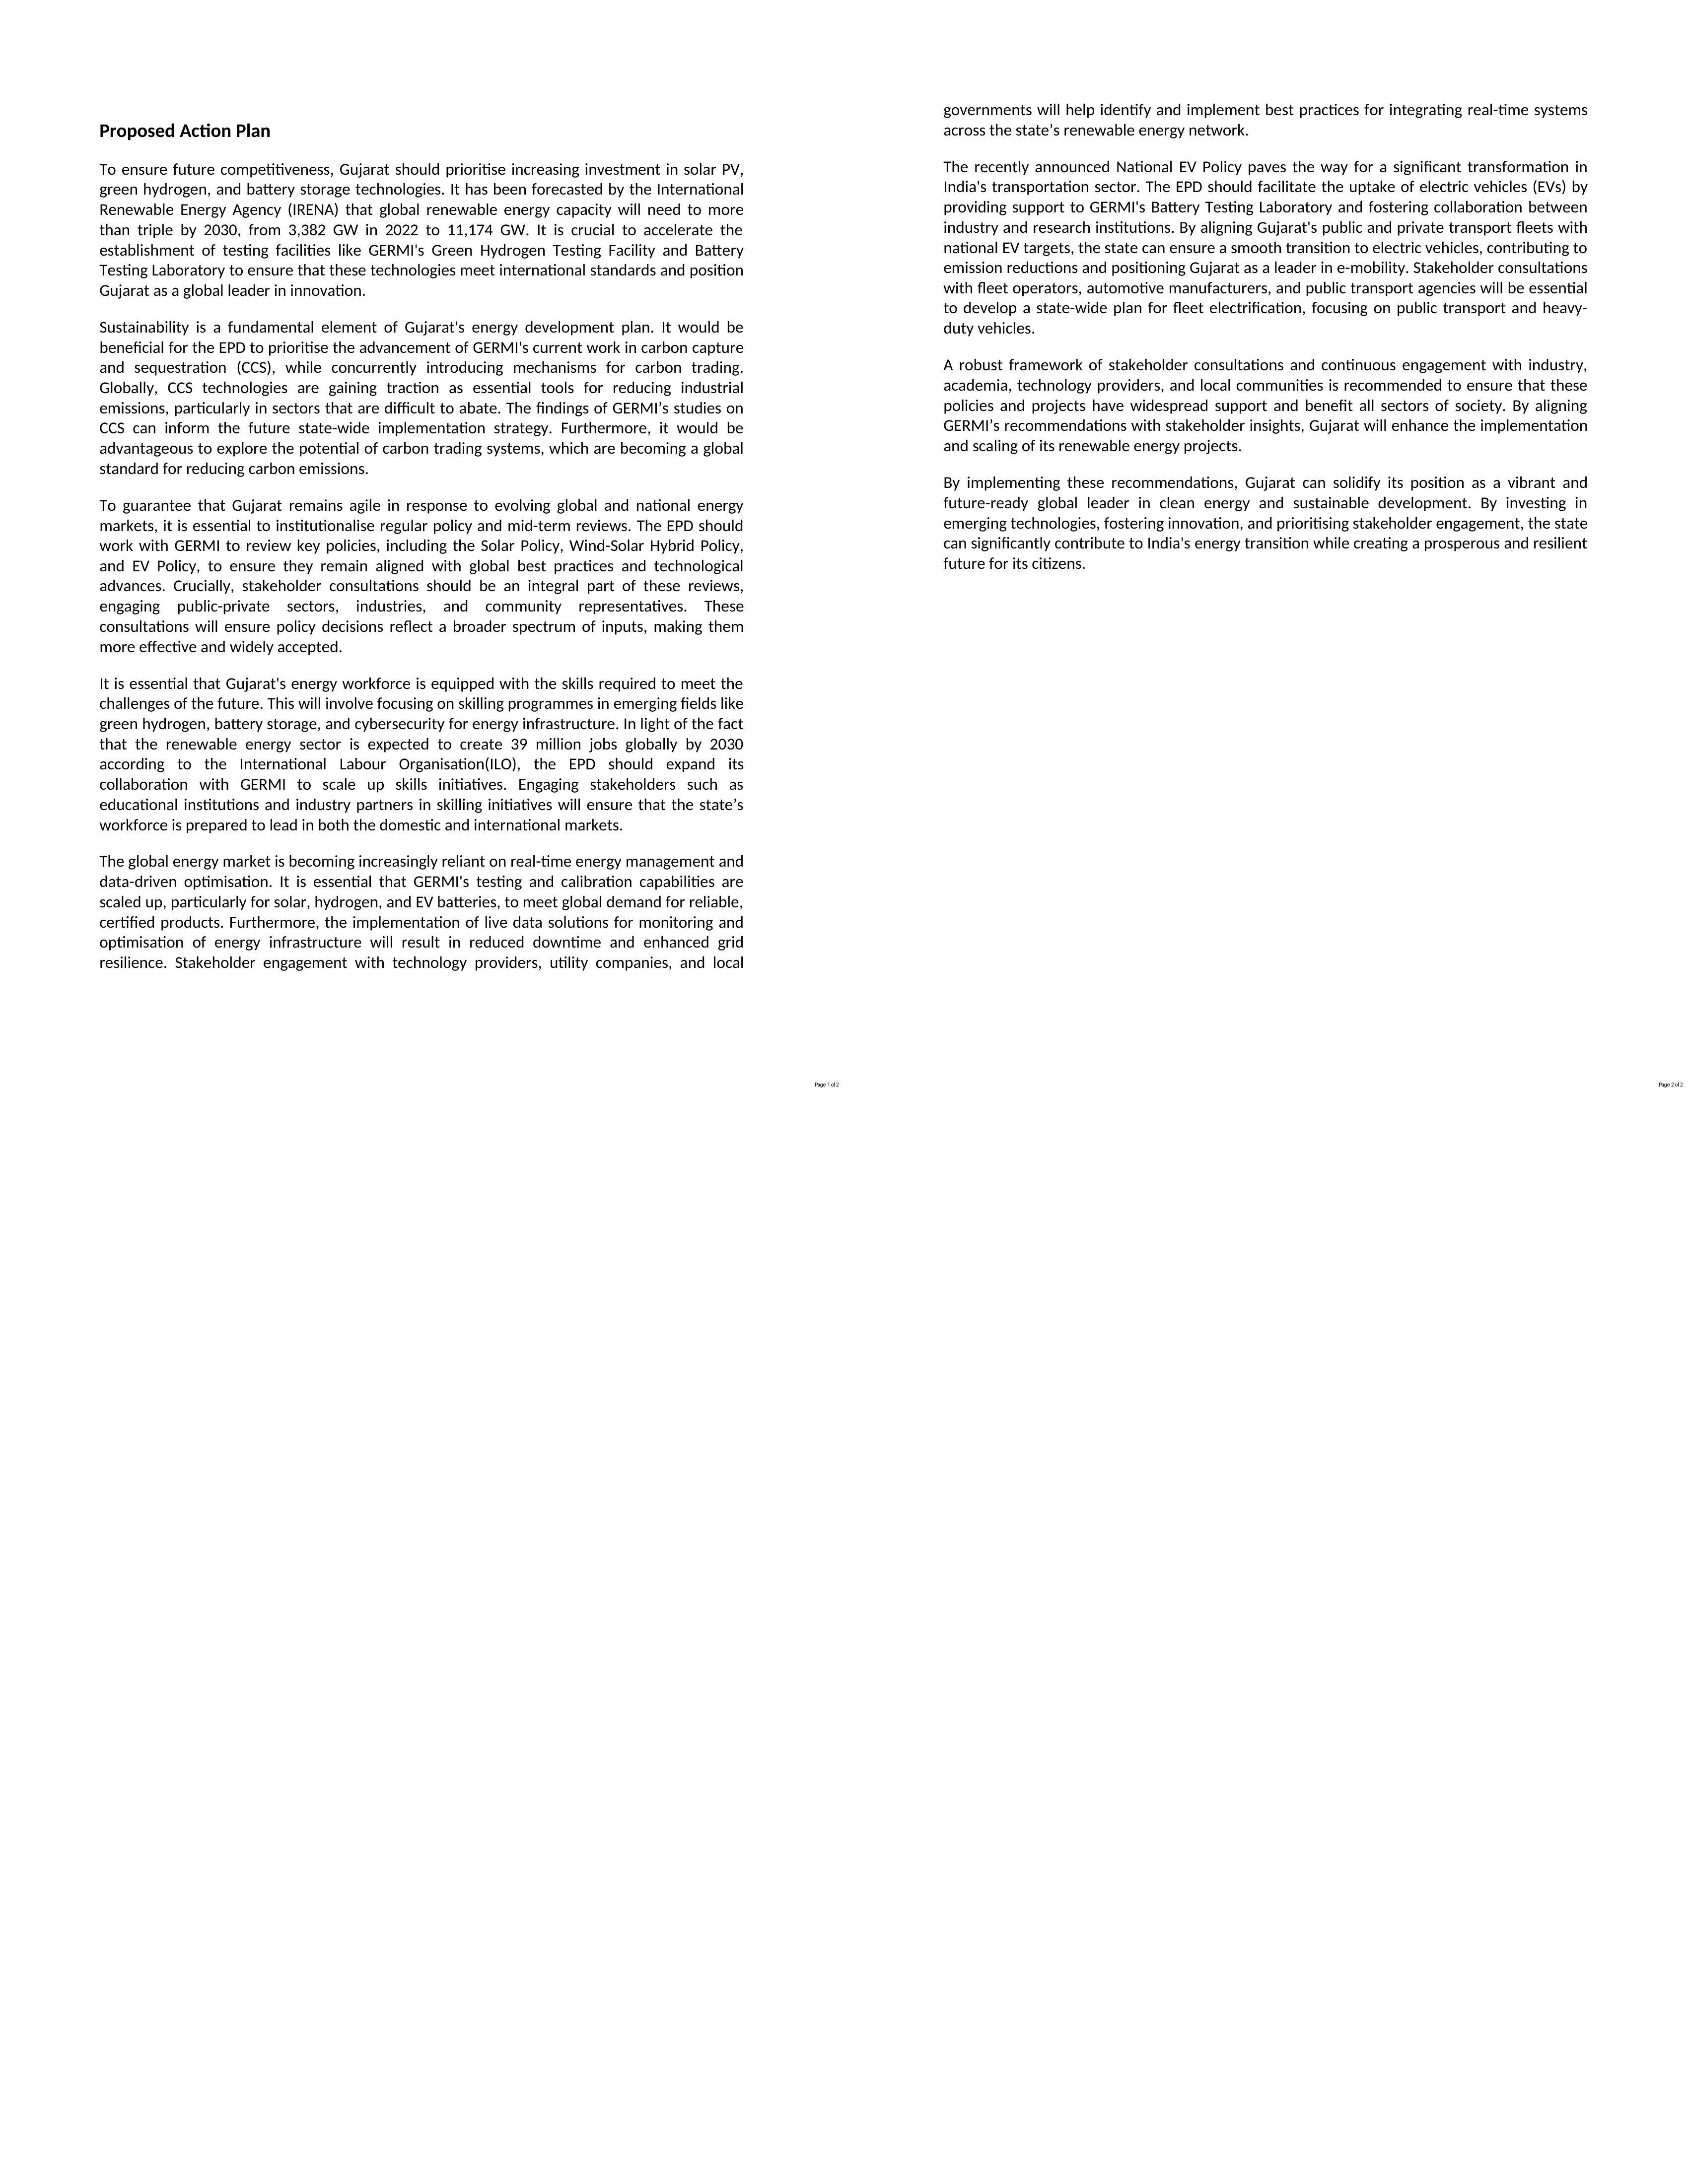

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [3]:
# Step 2: Import Necessary Libraries
import os
import math
from pdf2image import convert_from_path
from PIL import Image, ImageDraw, ImageFont
from google.colab import files
import tempfile

# Step 3: Function Definitions

def upload_file():
    """
    Prompts the user to upload a PDF or DOCX file and returns the file name.
    """
    uploaded = files.upload()
    if not uploaded:
        raise ValueError("No file uploaded. Please upload a PDF or DOCX file.")
    input_file = next(iter(uploaded))
    print(f"Uploaded file: {input_file}")
    return input_file

def convert_docx_to_pdf_libreoffice(input_path, output_path):
    """
    Converts a DOCX file to PDF using LibreOffice.

    Args:
        input_path (str): Path to the input DOCX file.
        output_path (str): Path where the output PDF will be saved.
    """
    print(f"Converting {input_path} to PDF using LibreOffice...")
    # LibreOffice command to convert DOCX to PDF
    !libreoffice --headless --convert-to pdf "{input_path}" --outdir .
    base_name = os.path.splitext(os.path.basename(input_path))[0]
    generated_pdf = f"{base_name}.pdf"
    if os.path.exists(generated_pdf):
        os.rename(generated_pdf, output_path)
        print(f"Converted to PDF: {output_path}")
    else:
        raise FileNotFoundError(f"Failed to convert {input_path} to PDF.")

def convert_pdf_to_images(pdf_path, dpi=200):
    """
    Converts each page of the PDF to a PIL Image object.

    Args:
        pdf_path (str): Path to the PDF file.
        dpi (int, optional): Resolution for the output images. Defaults to 200.

    Returns:
        List[Image.Image]: List of page images.
    """
    print(f"Converting PDF to images with DPI={dpi}...")
    images = convert_from_path(pdf_path, dpi=dpi)
    print(f"Total pages converted: {len(images)}")
    return images

def calculate_grid_size(num_pages):
    """
    Calculates the grid size (rows and columns) to arrange pages as square as possible.

    Args:
        num_pages (int): Total number of pages.

    Returns:
        Tuple[int, int]: Number of columns and rows.
    """
    grid_size = math.ceil(math.sqrt(num_pages))
    return grid_size, grid_size

def resize_images(images, standard_size=None):
    """
    Resizes all images to a standard size. If standard_size is not provided,
    uses the maximum width and height among all images.

    Args:
        images (List[Image.Image]): List of page images.
        standard_size (Tuple[int, int], optional): Desired size (width, height). Defaults to None.

    Returns:
        List[Image.Image]: List of resized images.
    """
    if standard_size is None:
        standard_width = max(img.width for img in images)
        standard_height = max(img.height for img in images)
    else:
        standard_width, standard_height = standard_size
    print(f"Standard image size for resizing: {standard_width}x{standard_height}")
    # Pillow 10 uses Image.Resampling.LANCZOS instead of Image.ANTIALIAS
    if hasattr(Image, 'Resampling'):
        resample_method = Image.Resampling.LANCZOS
    else:
        resample_method = Image.LANCZOS  # For older Pillow versions
    resized_images = [img.resize((standard_width, standard_height), resample=resample_method) for img in images]
    return resized_images

def add_page_number(image, page_number, total_pages):
    """
    Adds a page number to the bottom-right corner of the image.

    Args:
        image (Image.Image): The image to modify.
        page_number (int): Current page number (0-indexed).
        total_pages (int): Total number of pages.

    Returns:
        Image.Image: Image with page number added.
    """
    draw = ImageDraw.Draw(image)

    # Attempt to use a TrueType font; fallback to default if not available
    try:
        # You can upload a .ttf font file and specify its path if needed
        font = ImageFont.truetype("arial.ttf", 36)
    except IOError:
        font = ImageFont.load_default()

    text = f"Page {page_number + 1} of {total_pages}"

    # Calculate text size using textbbox (Pillow 10)
    bbox = draw.textbbox((0, 0), text, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]

    x = image.width - text_width - 10  # 10 pixels from the right
    y = image.height - text_height - 10  # 10 pixels from the bottom

    # Semi-transparent rectangle background for text
    rectangle_padding = 5
    draw.rectangle(
        [x - rectangle_padding, y - rectangle_padding, x + text_width + rectangle_padding, y + text_height + rectangle_padding],
        fill=(255, 255, 255, 128)
    )

    # Add text
    draw.text((x, y), text, fill="black", font=font)

    return image

def combine_images_into_grid(images, grid_cols, grid_rows, image_width, image_height):
    """
    Combines a list of images into a single grid image.

    Args:
        images (List[Image.Image]): List of page images.
        grid_cols (int): Number of columns in the grid.
        grid_rows (int): Number of rows in the grid.
        image_width (int): Width of each individual image.
        image_height (int): Height of each individual image.

    Returns:
        Image.Image: The combined grid image.
    """
    print(f"Combining images into a grid of {grid_cols} columns and {grid_rows} rows...")
    grid_image = Image.new('RGB', (grid_cols * image_width, grid_rows * image_height), color=(255, 255, 255))

    for idx, img in enumerate(images):
        row = idx // grid_cols
        col = idx % grid_cols
        x = col * image_width
        y = row * image_height
        grid_image.paste(img, (x, y))

    print("Images combined into grid successfully.")
    return grid_image

def process_document(input_file, output_file, add_page_numbers=False):
    """
    Processes the input document (PDF or DOCX) and creates a combined PNG image.

    Args:
        input_file (str): Uploaded file name.
        output_file (str): Desired output PNG file name.
        add_page_numbers (bool, optional): Whether to add page numbers to images. Defaults to False.

    Returns:
        Image.Image: The final combined image.
    """
    # Determine file type
    file_ext = os.path.splitext(input_file)[1].lower()

    if file_ext == '.docx':
        # Convert DOCX to PDF
        temp_pdf = "temp_converted.pdf"
        convert_docx_to_pdf_libreoffice(input_file, temp_pdf)
        pdf_path = temp_pdf
    elif file_ext == '.pdf':
        pdf_path = input_file
    else:
        raise ValueError("Unsupported file type. Please upload a PDF or DOCX file.")

    # Convert PDF to images
    images = convert_pdf_to_images(pdf_path, dpi=200)
    num_pages = len(images)

    # Optionally add page numbers
    if add_page_numbers:
        print("Adding page numbers to images...")
        for idx in range(num_pages):
            images[idx] = add_page_number(images[idx], idx, num_pages)
        print("Page numbers added.")

    # Calculate grid size
    grid_cols, grid_rows = calculate_grid_size(num_pages)

    # Resize images for consistency
    resized_images = resize_images(images)
    image_width, image_height = resized_images[0].size

    # Combine images into grid
    combined_image = combine_images_into_grid(resized_images, grid_cols, grid_rows, image_width, image_height)

    # Save the combined image
    combined_image.save(output_file, 'PNG')
    print(f"Combined image saved as {output_file}")

    # Clean up temporary PDF if DOCX was converted
    if file_ext == '.docx':
        if os.path.exists(pdf_path):
            os.remove(pdf_path)
            print(f"Temporary file {pdf_path} removed.")

    return combined_image

# Step 4: User Interaction and Processing

try:
    # Upload the file
    input_filename = upload_file()

    # Define output file name
    output_filename = "combined_document.png"  # You can change this as needed

    # Set whether to add page numbers (True or False)
    add_page_numbers = True  # Change to False if you don't want page numbers

    # Process the document
    final_image = process_document(input_filename, output_filename, add_page_numbers)

    # Display the combined image inline (optional)
    display(final_image)

    # Provide a download link for the combined image
    print("Preparing download...")
    files.download(output_filename)

except Exception as e:
    print(f"An error occurred: {e}")